In [1]:
import sys
sys.path.append("../")
sys.path.append("../../")
sys.path.append("../../../")
import os
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import default_argument_parser
from launch_utils import setup
from pgrcnn.utils.custom_visualizer import JerseyNumberVisualizer
import random, cv2
import matplotlib.pyplot as plt
import torch
import kornia
import numpy as np
# for t-sne
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time
%matplotlib notebook
# %matplotlib inline

args = default_argument_parser().parse_args(args=[])
# lazy add config file
args.config_file = "../../configs/faster_rcnn_R_50_FPN_1x.yaml"
cfg = setup(args)

dataset_root = os.path.join('../../../../', 'datasets/jnw') # working dir is the current file
dataset_dir = os.path.join(dataset_root, 'total/')
annotation_dir = os.path.join(dataset_root, 'annotations/processed_annotations.json')
# register_jerseynumbers()
# dataset_dicts = get_dicts("jerseynumbers", annotation_dir, split=[0,1,2,3])
# register_jerseynumbers()
dataset_dicts = DatasetCatalog.get("jerseynumbers_train")
jnw_metadata = MetadataCatalog.get("jerseynumbers_train")


[04/30 13:33:33 detectron2]: Rank of current process: 0. World size: 1
[04/30 13:33:33 detectron2]: Environment info:
------------------------  ------------------------------------------------------------------------------
sys.platform              darwin
Python                    3.8.1 (default, Jan  8 2020, 16:15:59) [Clang 4.0.1 (tags/RELEASE_401/final)]
numpy                     1.18.1
detectron2                0.1.1 @/Users/henry/Research/da-det/detectron2
detectron2 compiler       clang 11.0.0
detectron2 CUDA compiler  not available
DETECTRON2_ENV_MODULE     <not set>
PyTorch                   1.4.0 @/Users/henry/anaconda3/envs/dev/lib/python3.8/site-packages/torch
PyTorch debug build       False
CUDA available            False
Pillow                    7.0.0
torchvision               0.5.0 @/Users/henry/anaconda3/envs/dev/lib/python3.8/site-packages/torchvision
fvcore                    0.1.dev200322
cv2                       4.2.0
------------------------  ---------------------

[04/30 13:33:33 detectron2]: Full config saved to ./output/config.yaml
[04/30 13:33:33 d2.utils.env]: Using a generated random seed 33984786


file name:  /Users/henry/Research/da-det/datasets/jnw/total/15165_frame_1288_2.png
{'image_id': 1494, 'file_name': '/Users/henry/Research/da-det/datasets/jnw/total/15165_frame_1288_2.png', 'width': 128, 'height': 226, 'video_id': 1, 'annotations': [{'digit_bboxes': [[61, 41, 73, 62]], 'digit_labels': [6], 'keypoints': [47, 40, 2, 83, 37, 2, 77, 92, 2, 59, 95, 2], 'person_bbox': [34, 8, 101, 209], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'digit_ids': [6]}]}


<IPython.core.display.Javascript object>


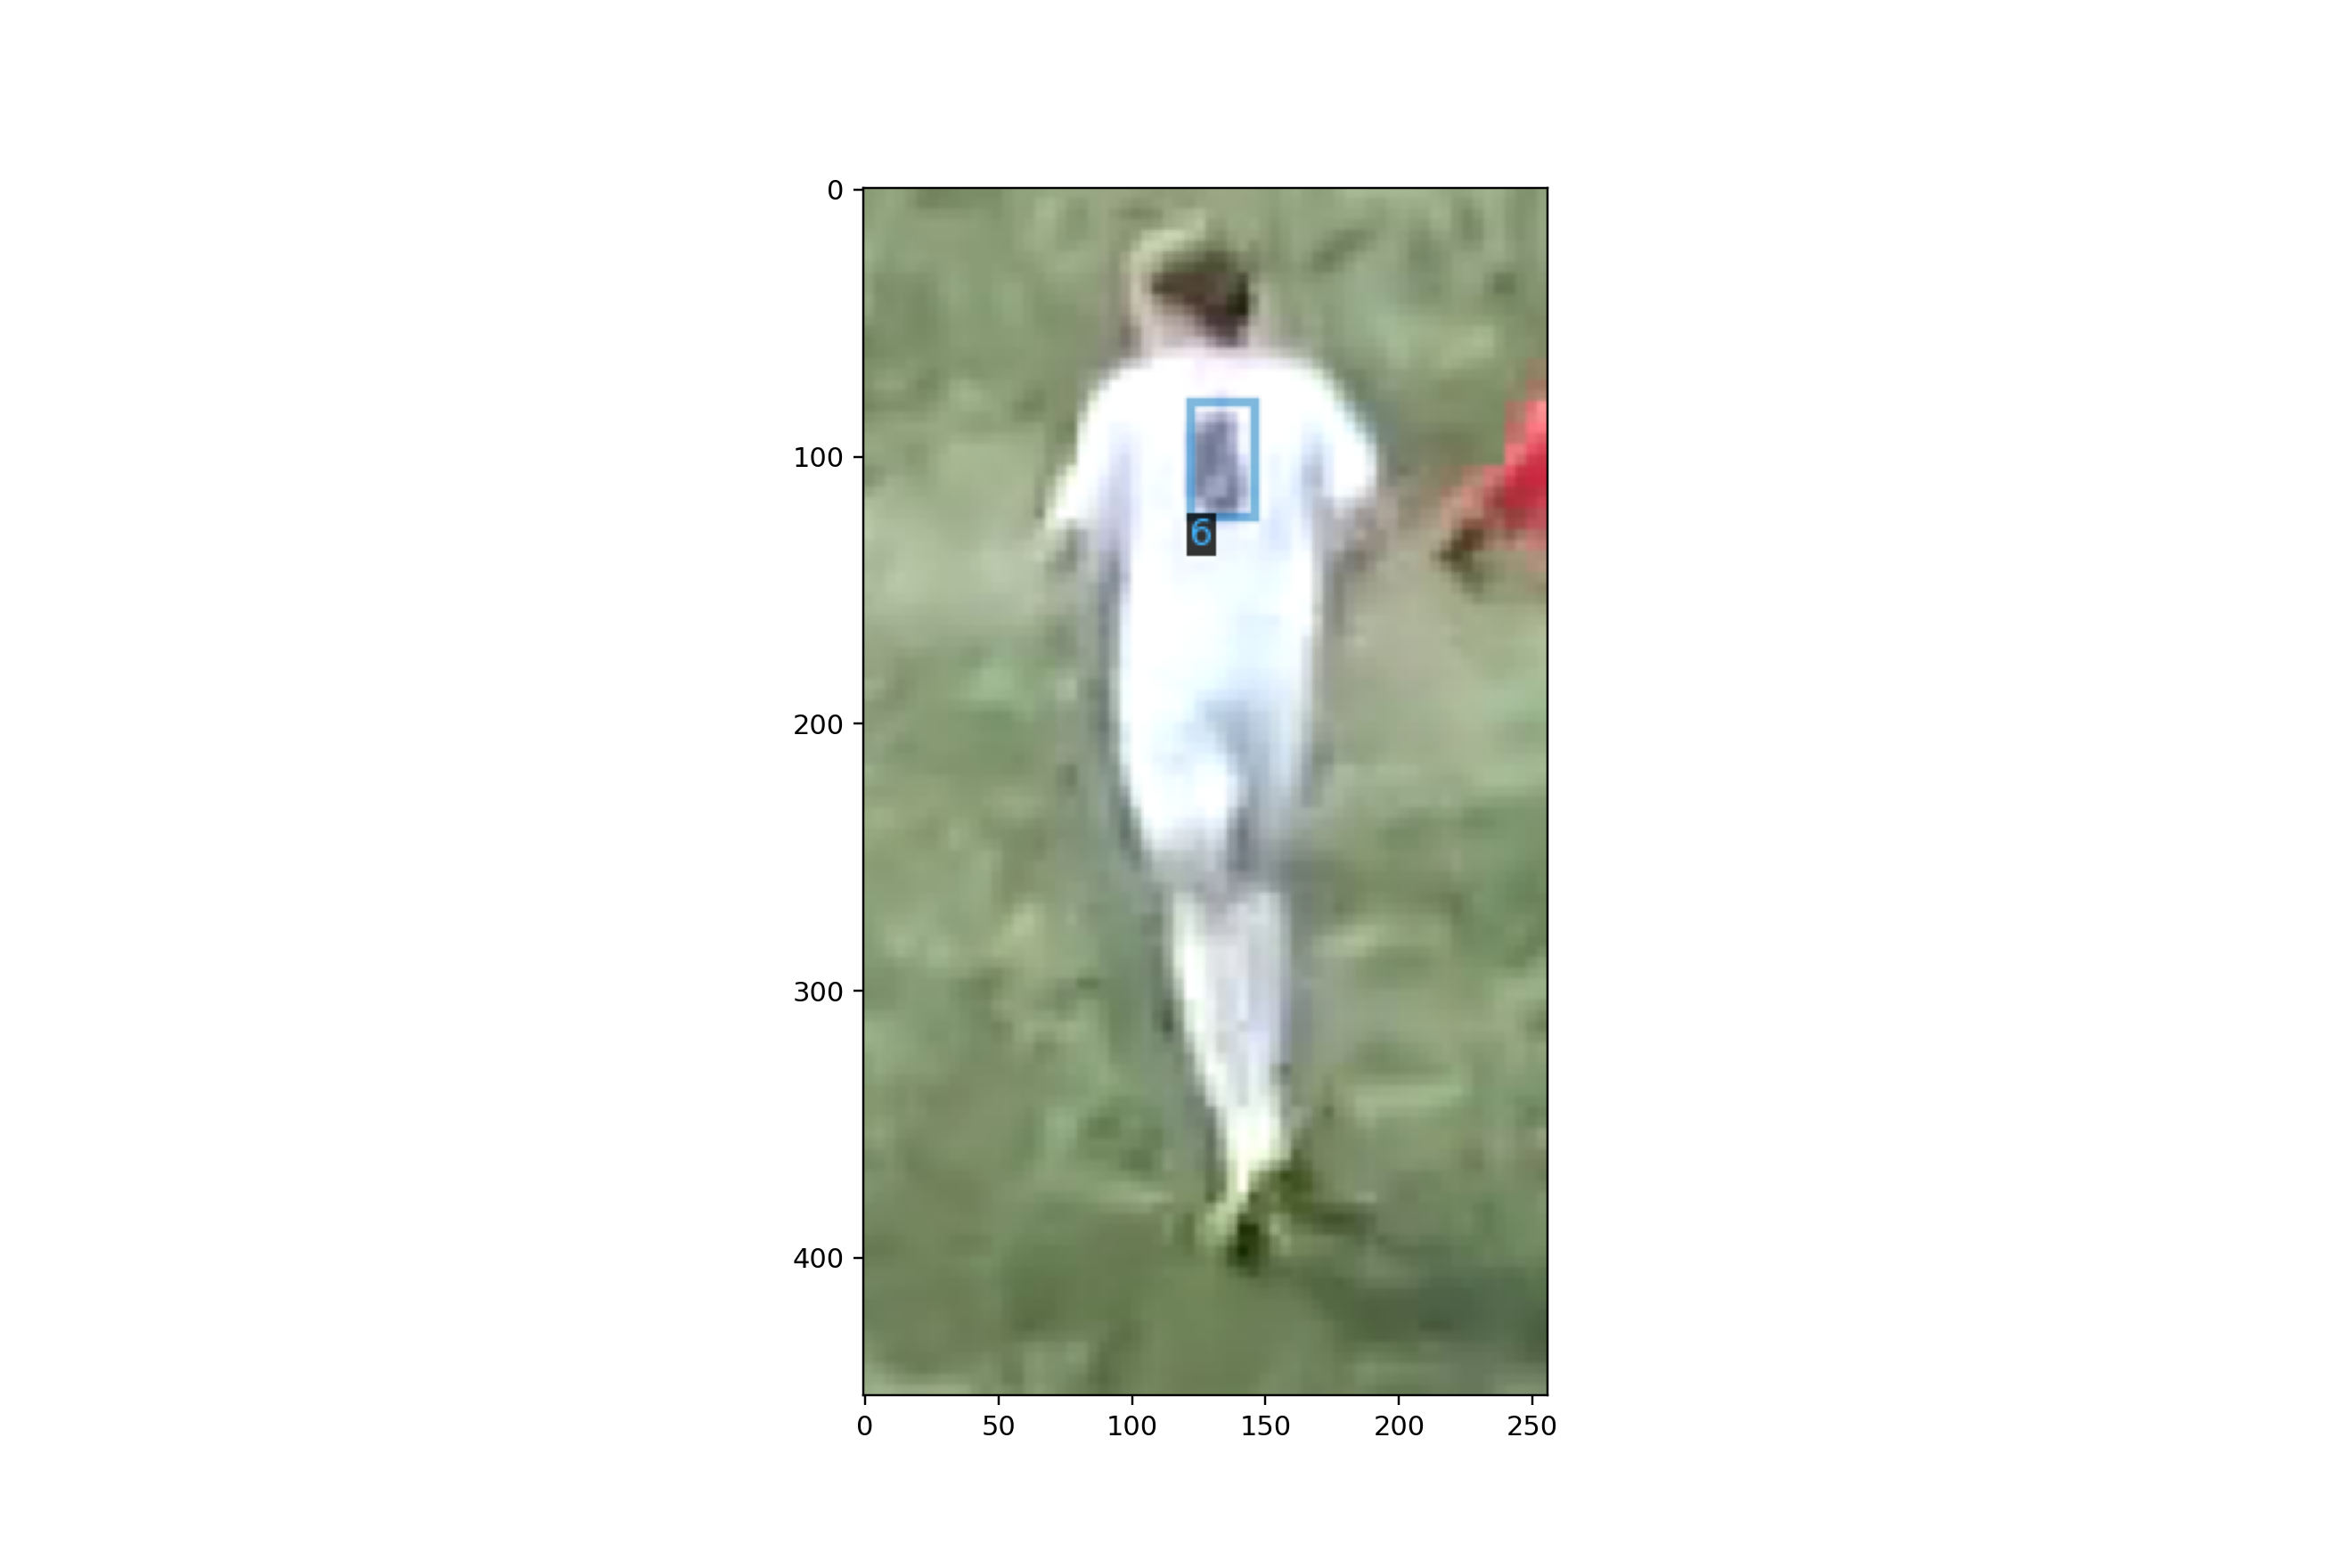

In [6]:
# dataset test
VIS_DATASET = True
NUM_IMAGE_SHOW = 1
if VIS_DATASET:
    for d in random.sample(dataset_dicts, NUM_IMAGE_SHOW):
        print("file name: ", os.path.abspath(d['file_name']))
        print(d)
        img = cv2.imread(d["file_name"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        visualizer = JerseyNumberVisualizer(img, metadata=jnw_metadata, scale=2)
        vis = visualizer.draw_dataset_dict(d)
        plt.figure(figsize = (12,8))
        
        plt.imshow(vis.get_image())
        plt.show()

In [4]:
def get_perspective_mat(dataset_dicts):
    mats = []
    for dataset_dict in dataset_dicts:
#         print(dataset_dict)
        img_size = np.array([dataset_dict['width'], dataset_dict['height']])
        for instance in dataset_dict['annotations']:
            # if both keypoints and digit bboxes exist
            if len(instance['keypoints']) > 0 and len(instance['digit_bboxes']) > 0:
                num_digit_bboxes = len(instance['digit_bboxes'])
                keypoints = np.array([[instance['keypoints'][3*i], instance['keypoints'][3*i+1]] \
                    for i in range(len(instance['keypoints']) // 3)])
                
                # digit bboxes
                digit_bboxes = np.array([[[digit_bbox[0], digit_bbox[1]], [digit_bbox[2], digit_bbox[1]], \
                                            [digit_bbox[2], digit_bbox[3]], [digit_bbox[0], digit_bbox[3]], \
                                    ] for digit_bbox in instance['digit_bboxes']])

                # normalized coordinates
                keypoints = keypoints / img_size
                digit_bboxes = digit_bboxes / img_size
                
                # keypoints 
                points_src = torch.tensor([keypoints], dtype=torch.float).repeat(num_digit_bboxes,1,1)
                # digit bbox four corners
                points_dst = torch.tensor(digit_bboxes, dtype=torch.float)
                
#                 print(points_src.shape, points_dst.shape)
                
                # compute perspective transform
                M: torch.tensor = kornia.get_perspective_transform(points_src, points_dst)
#                 print(M.size())
                mats.append(M)
            
#         break
    return mats
        
mats = get_perspective_mat(dataset_dicts)
mats = torch.cat(mats) # torch.Size([6160, 3, 3])
mats = mats.view(-1, 9).numpy()
print(mats.shape)

torch.Size([2, 4, 2]) torch.Size([2, 4, 2])
(2, 9)
[[ 9.9999964e-01  3.3619862e-15  6.5301471e-08 -1.2736037e-07
   9.9999982e-01  5.8510555e-08 -4.1186701e-07 -1.7596462e-14
   1.0000000e+00]
 [ 9.9999970e-01  1.9982703e-14  6.7461016e-08 -1.1424223e-07
   9.9999982e-01  6.9837249e-08 -3.9351681e-07  4.4488986e-14
   1.0000000e+00]]


<IPython.core.display.Javascript object>


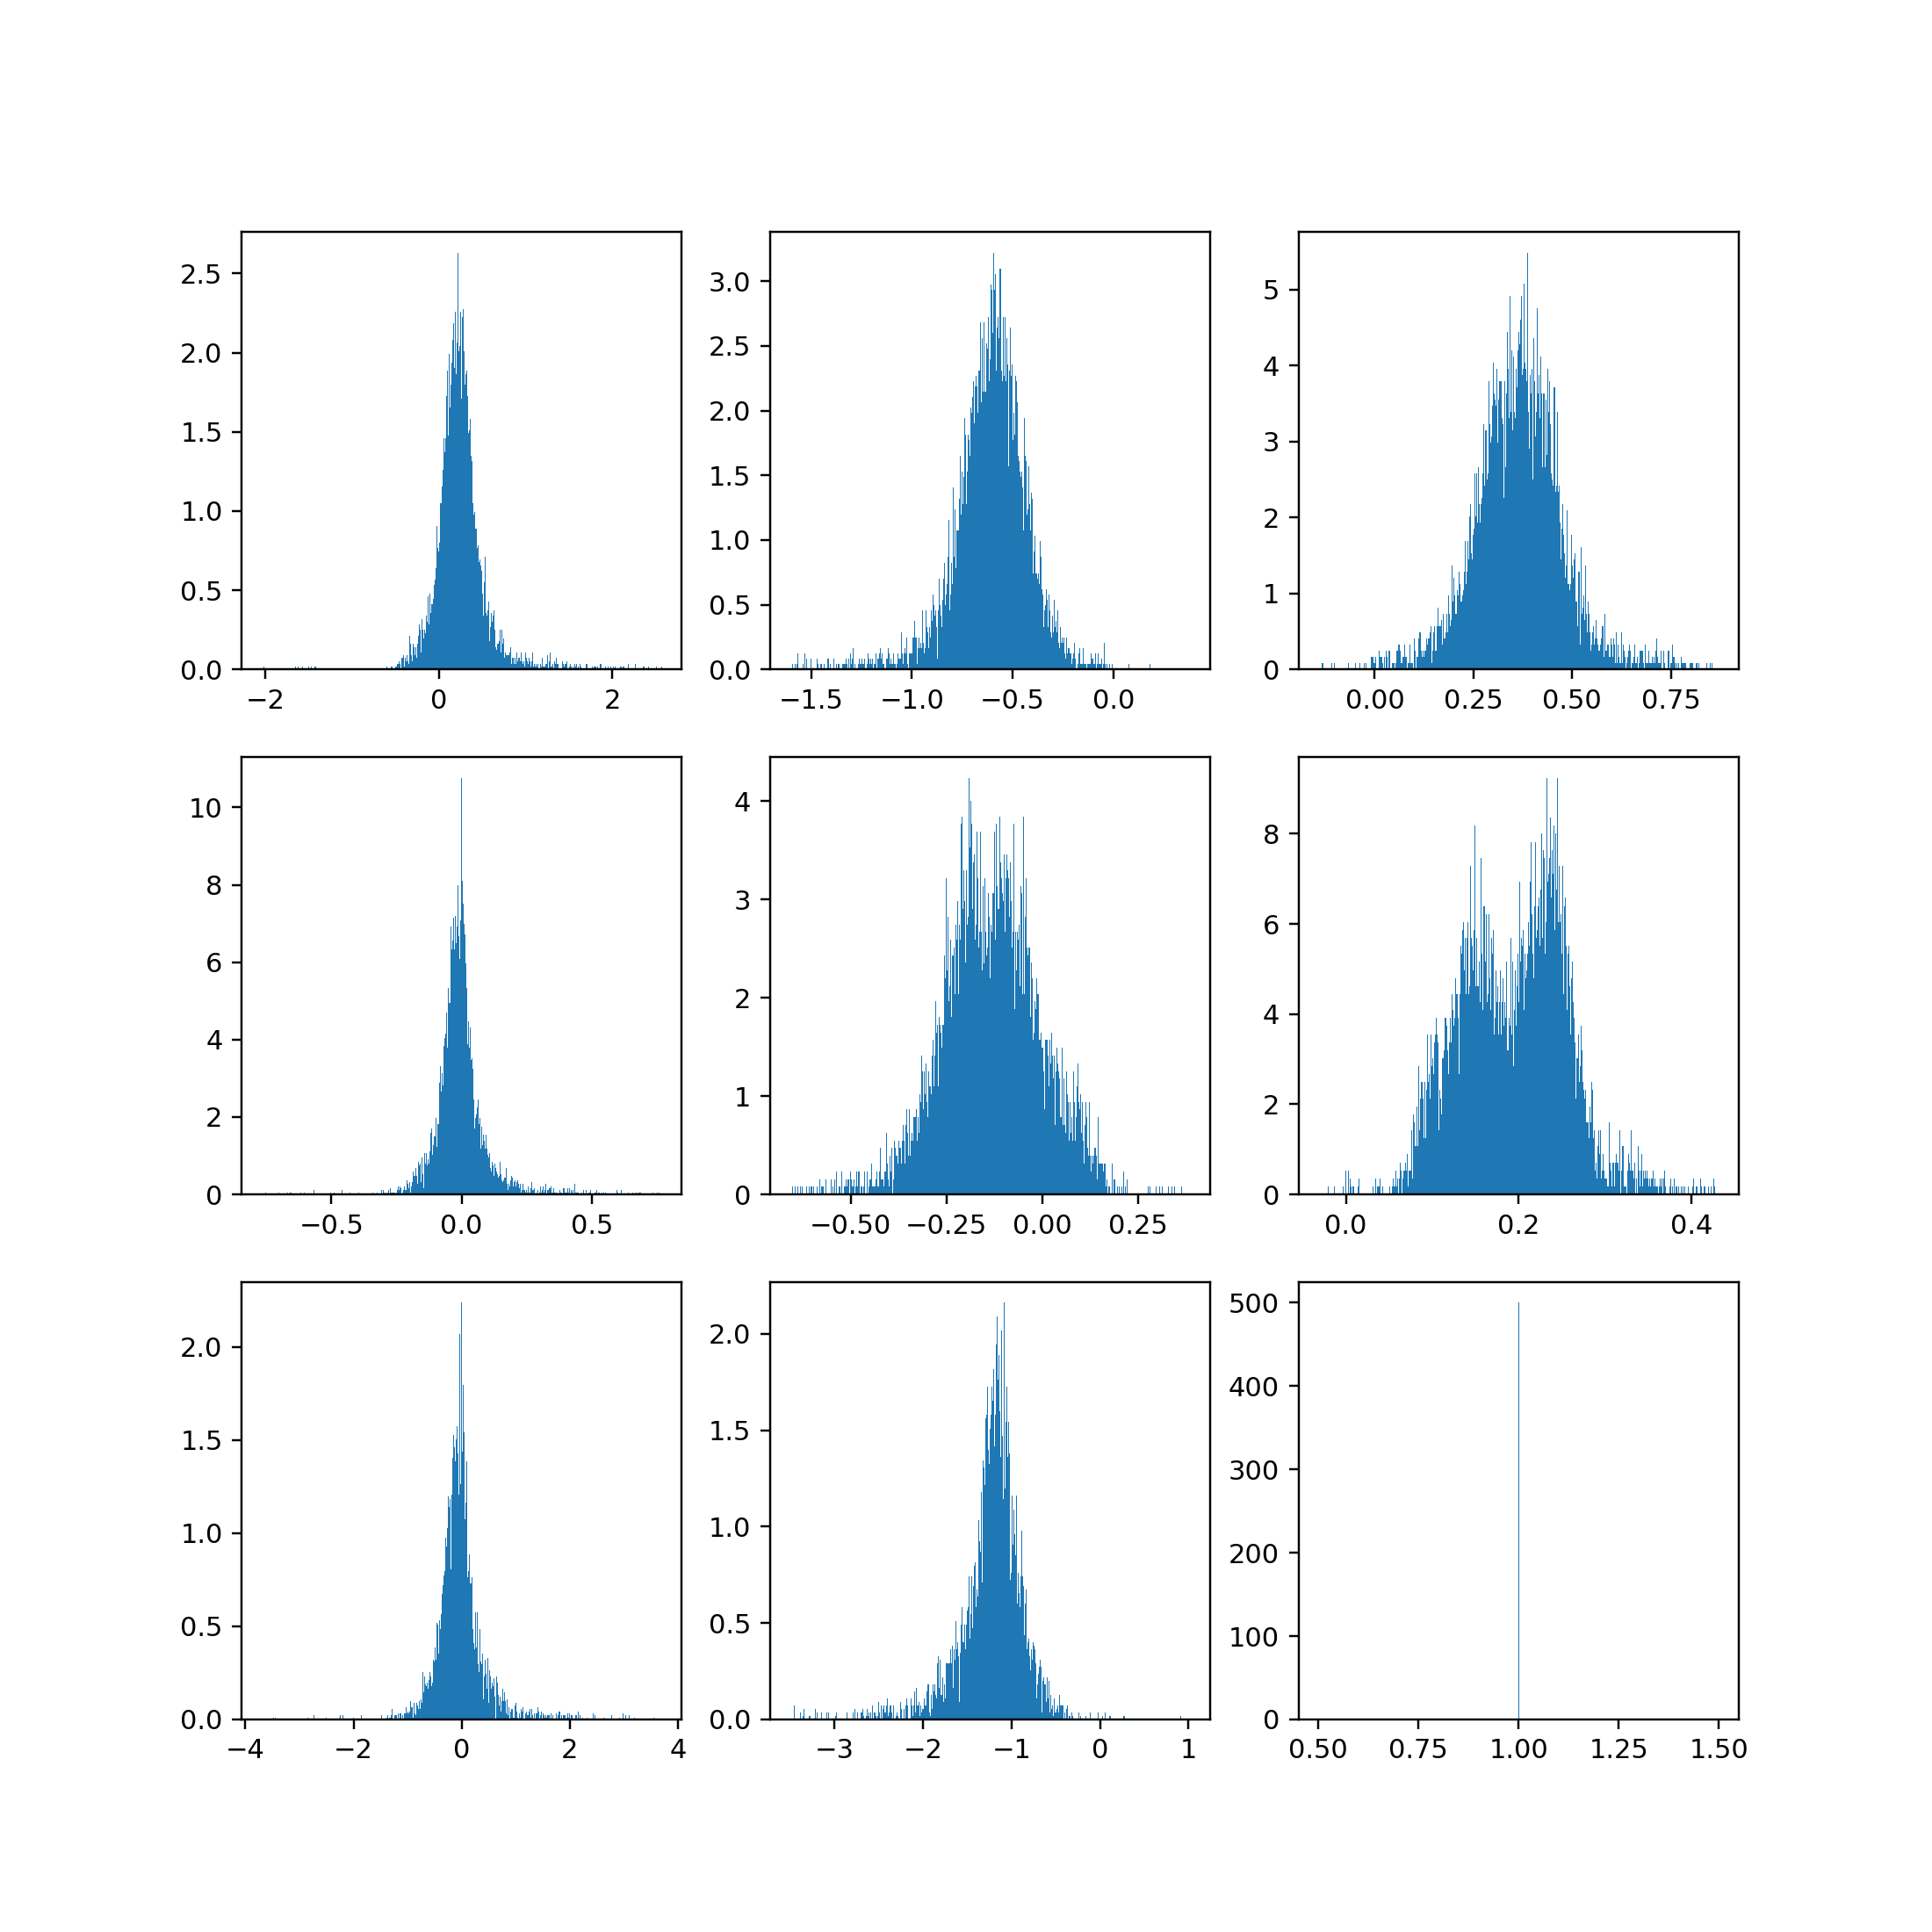

In [5]:
(fig, subplots) = plt.subplots(3, 3, figsize=(10, 10))
for i in range(mats.shape[1]):
    ax = subplots[i//3, i%3]
    val_range = (np.mean(mats[:, i]) - 3 * np.std(mats[:, i]), np.mean(mats[:, i]) + 3 * np.std(mats[:, i]))
    ax.hist(mats[:, i], bins=500, density=True, range=val_range)
    ax.axis('tight')

<IPython.core.display.Javascript object>


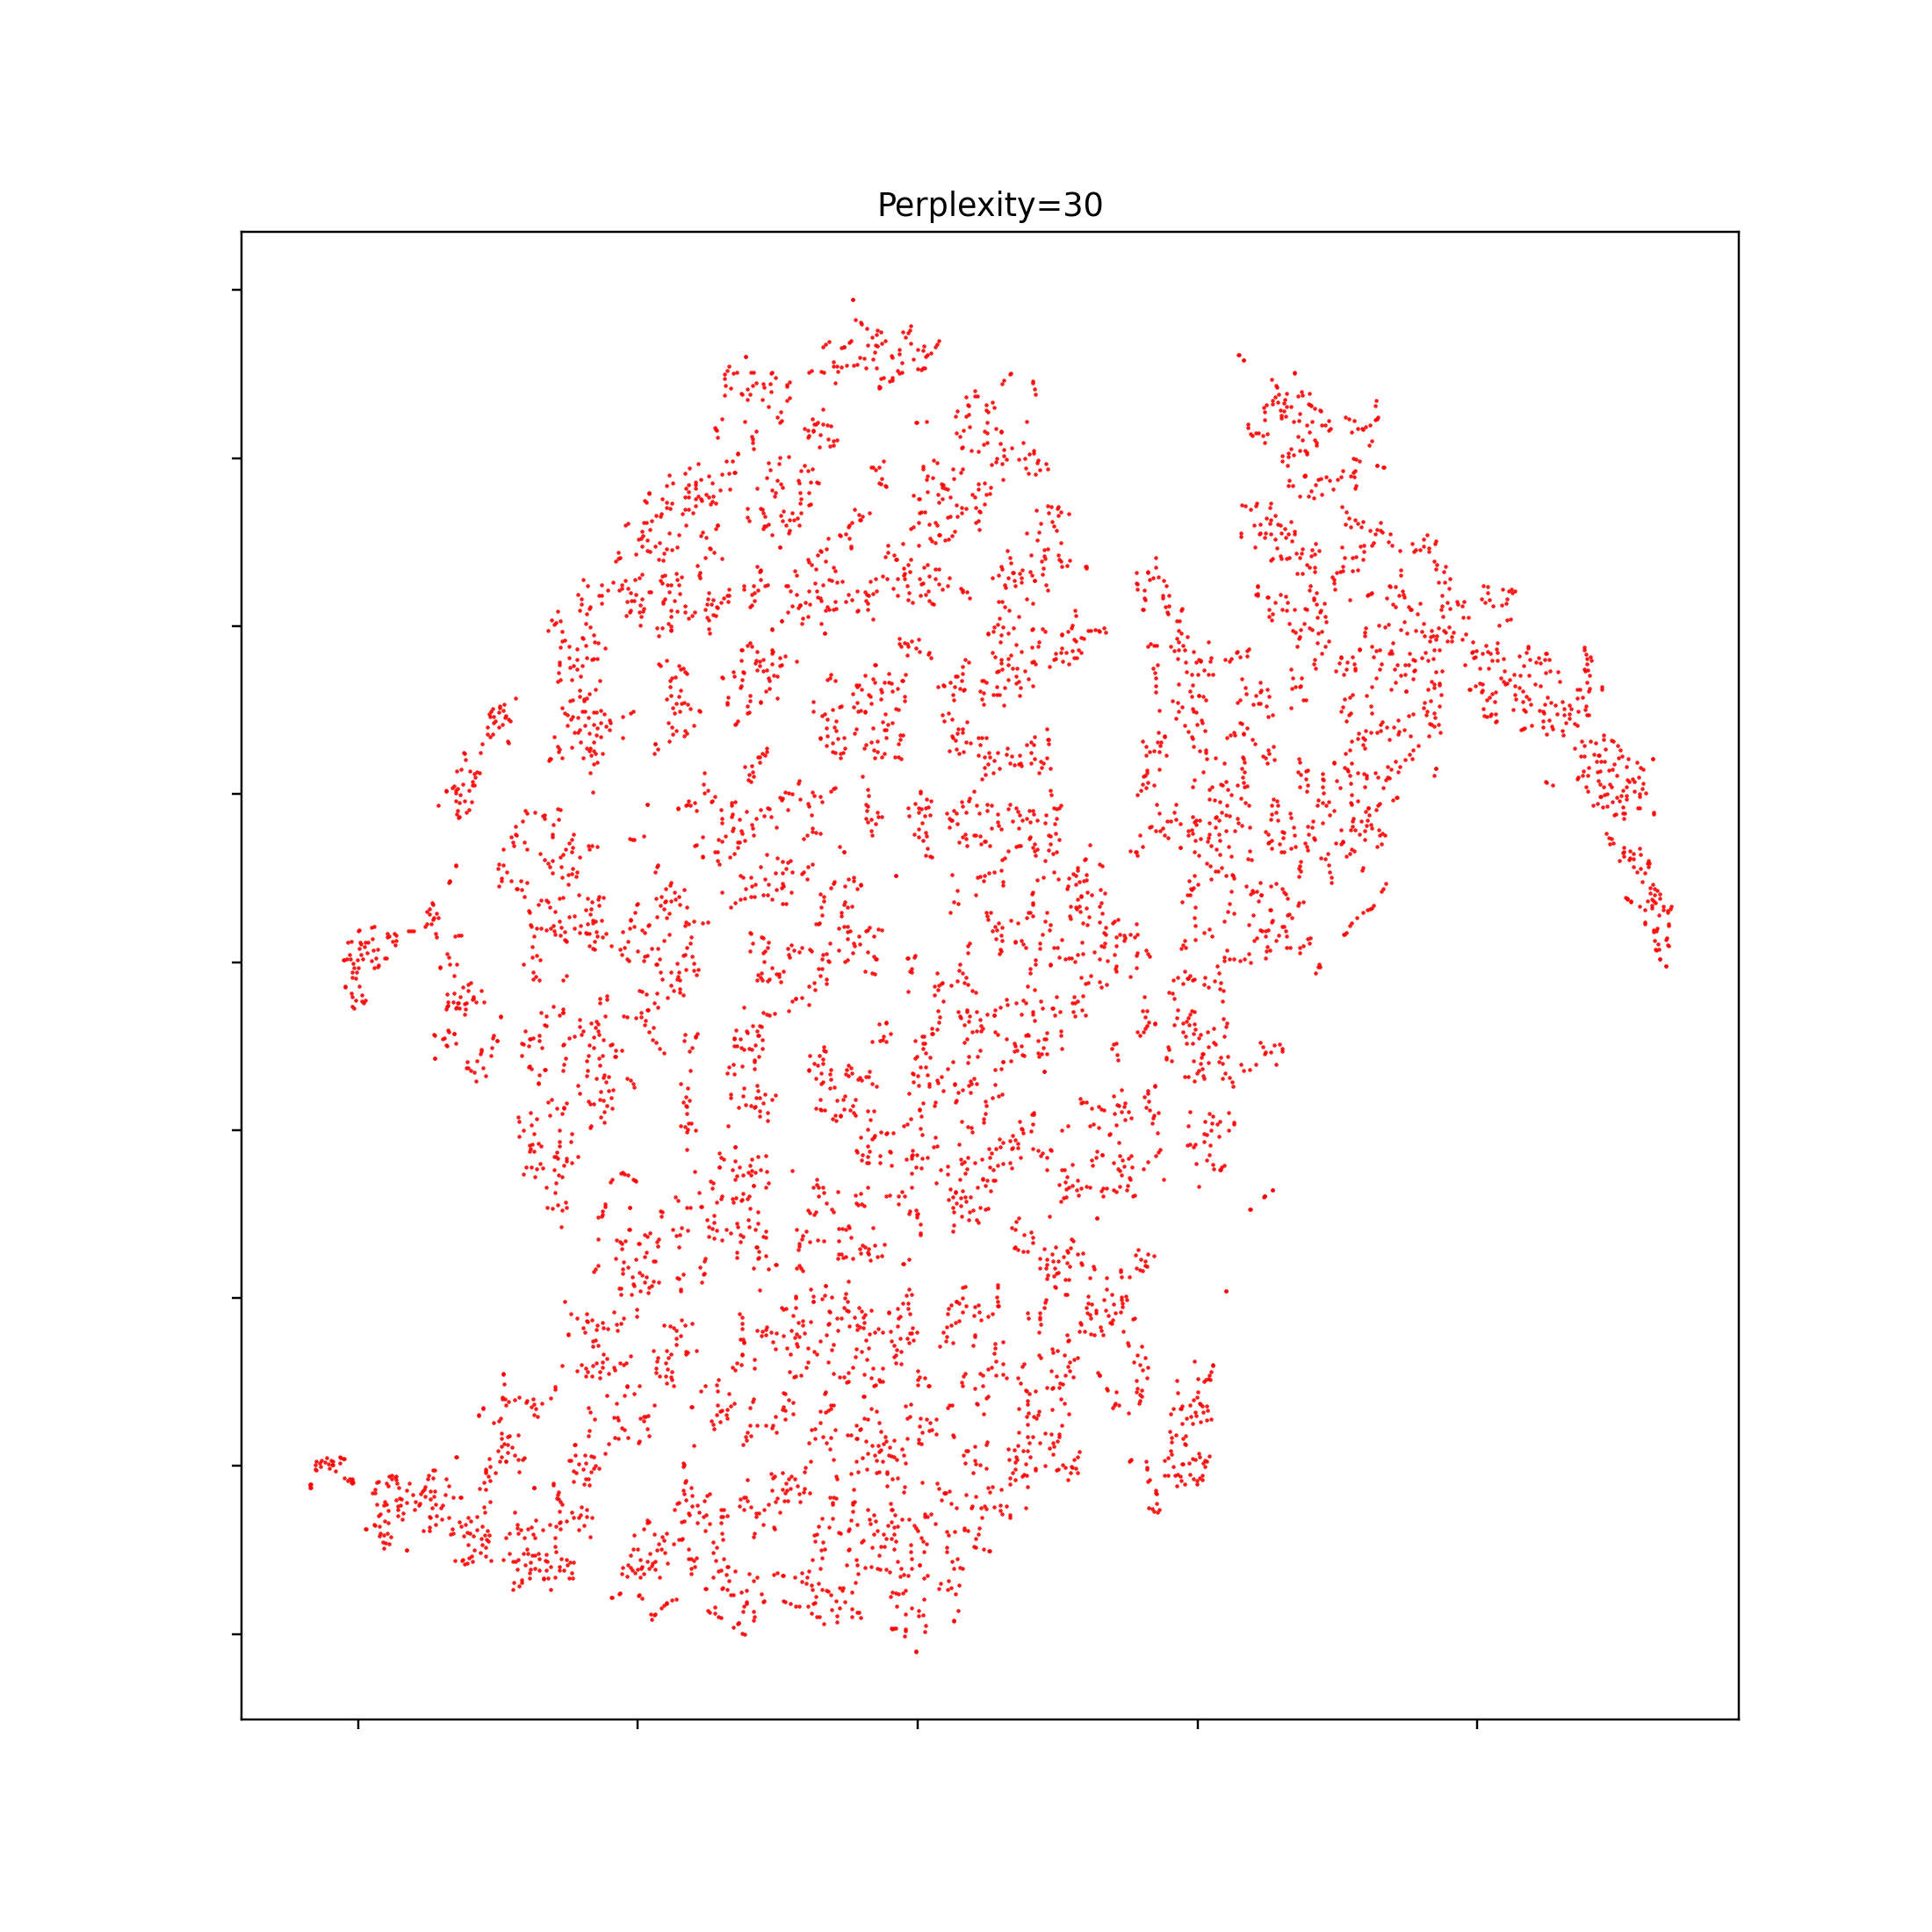

perplexity=30 in 34 sec


In [38]:
# t-sne
n_samples = 300
n_components = 2
perplexities = [30]
(fig, subplots) = plt.subplots(1, len(perplexities), figsize=(10, 10))

for i, perplexity in enumerate(perplexities):
    ax = subplots[i] if isinstance(subplots, list) else subplots

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity, n_iter=2500)
    Y = tsne.fit_transform(mats)
    t1 = time()
    print("perplexity=%d in %.2g sec" % (perplexity, t1 - t0))
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c="r", s=0.2)
#     ax.scatter(Y[green, 0], Y[green, 1], c="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
#     break

[-15.254207    -5.9907527   -3.1656442   -5.2019587   -2.8012514
  -0.13465607 -27.440487   -14.172837     1.        ] [18.062006   5.256197   3.5222435  7.282058   2.5490851  0.8156953
 31.89323   12.143411   1.       ]
[[ 8.06530058e-01 -1.14070855e-01]
 [-3.10418739e+01 -2.32807994e-01]
 [-2.46664971e-01  2.83264145e-02]
 [ 2.35259895e+01 -2.31503582e+00]
 [ 4.64857721e+00 -4.51404810e-01]
 [-9.11562157e+00  7.42439747e-01]
 [ 1.27290955e+01  2.26817444e-01]
 [ 3.88700104e+01  5.48756838e+00]]
-35.31731033325195 40.243499755859375
-4.61673903465271 6.821112632751465


<IPython.core.display.Javascript object>


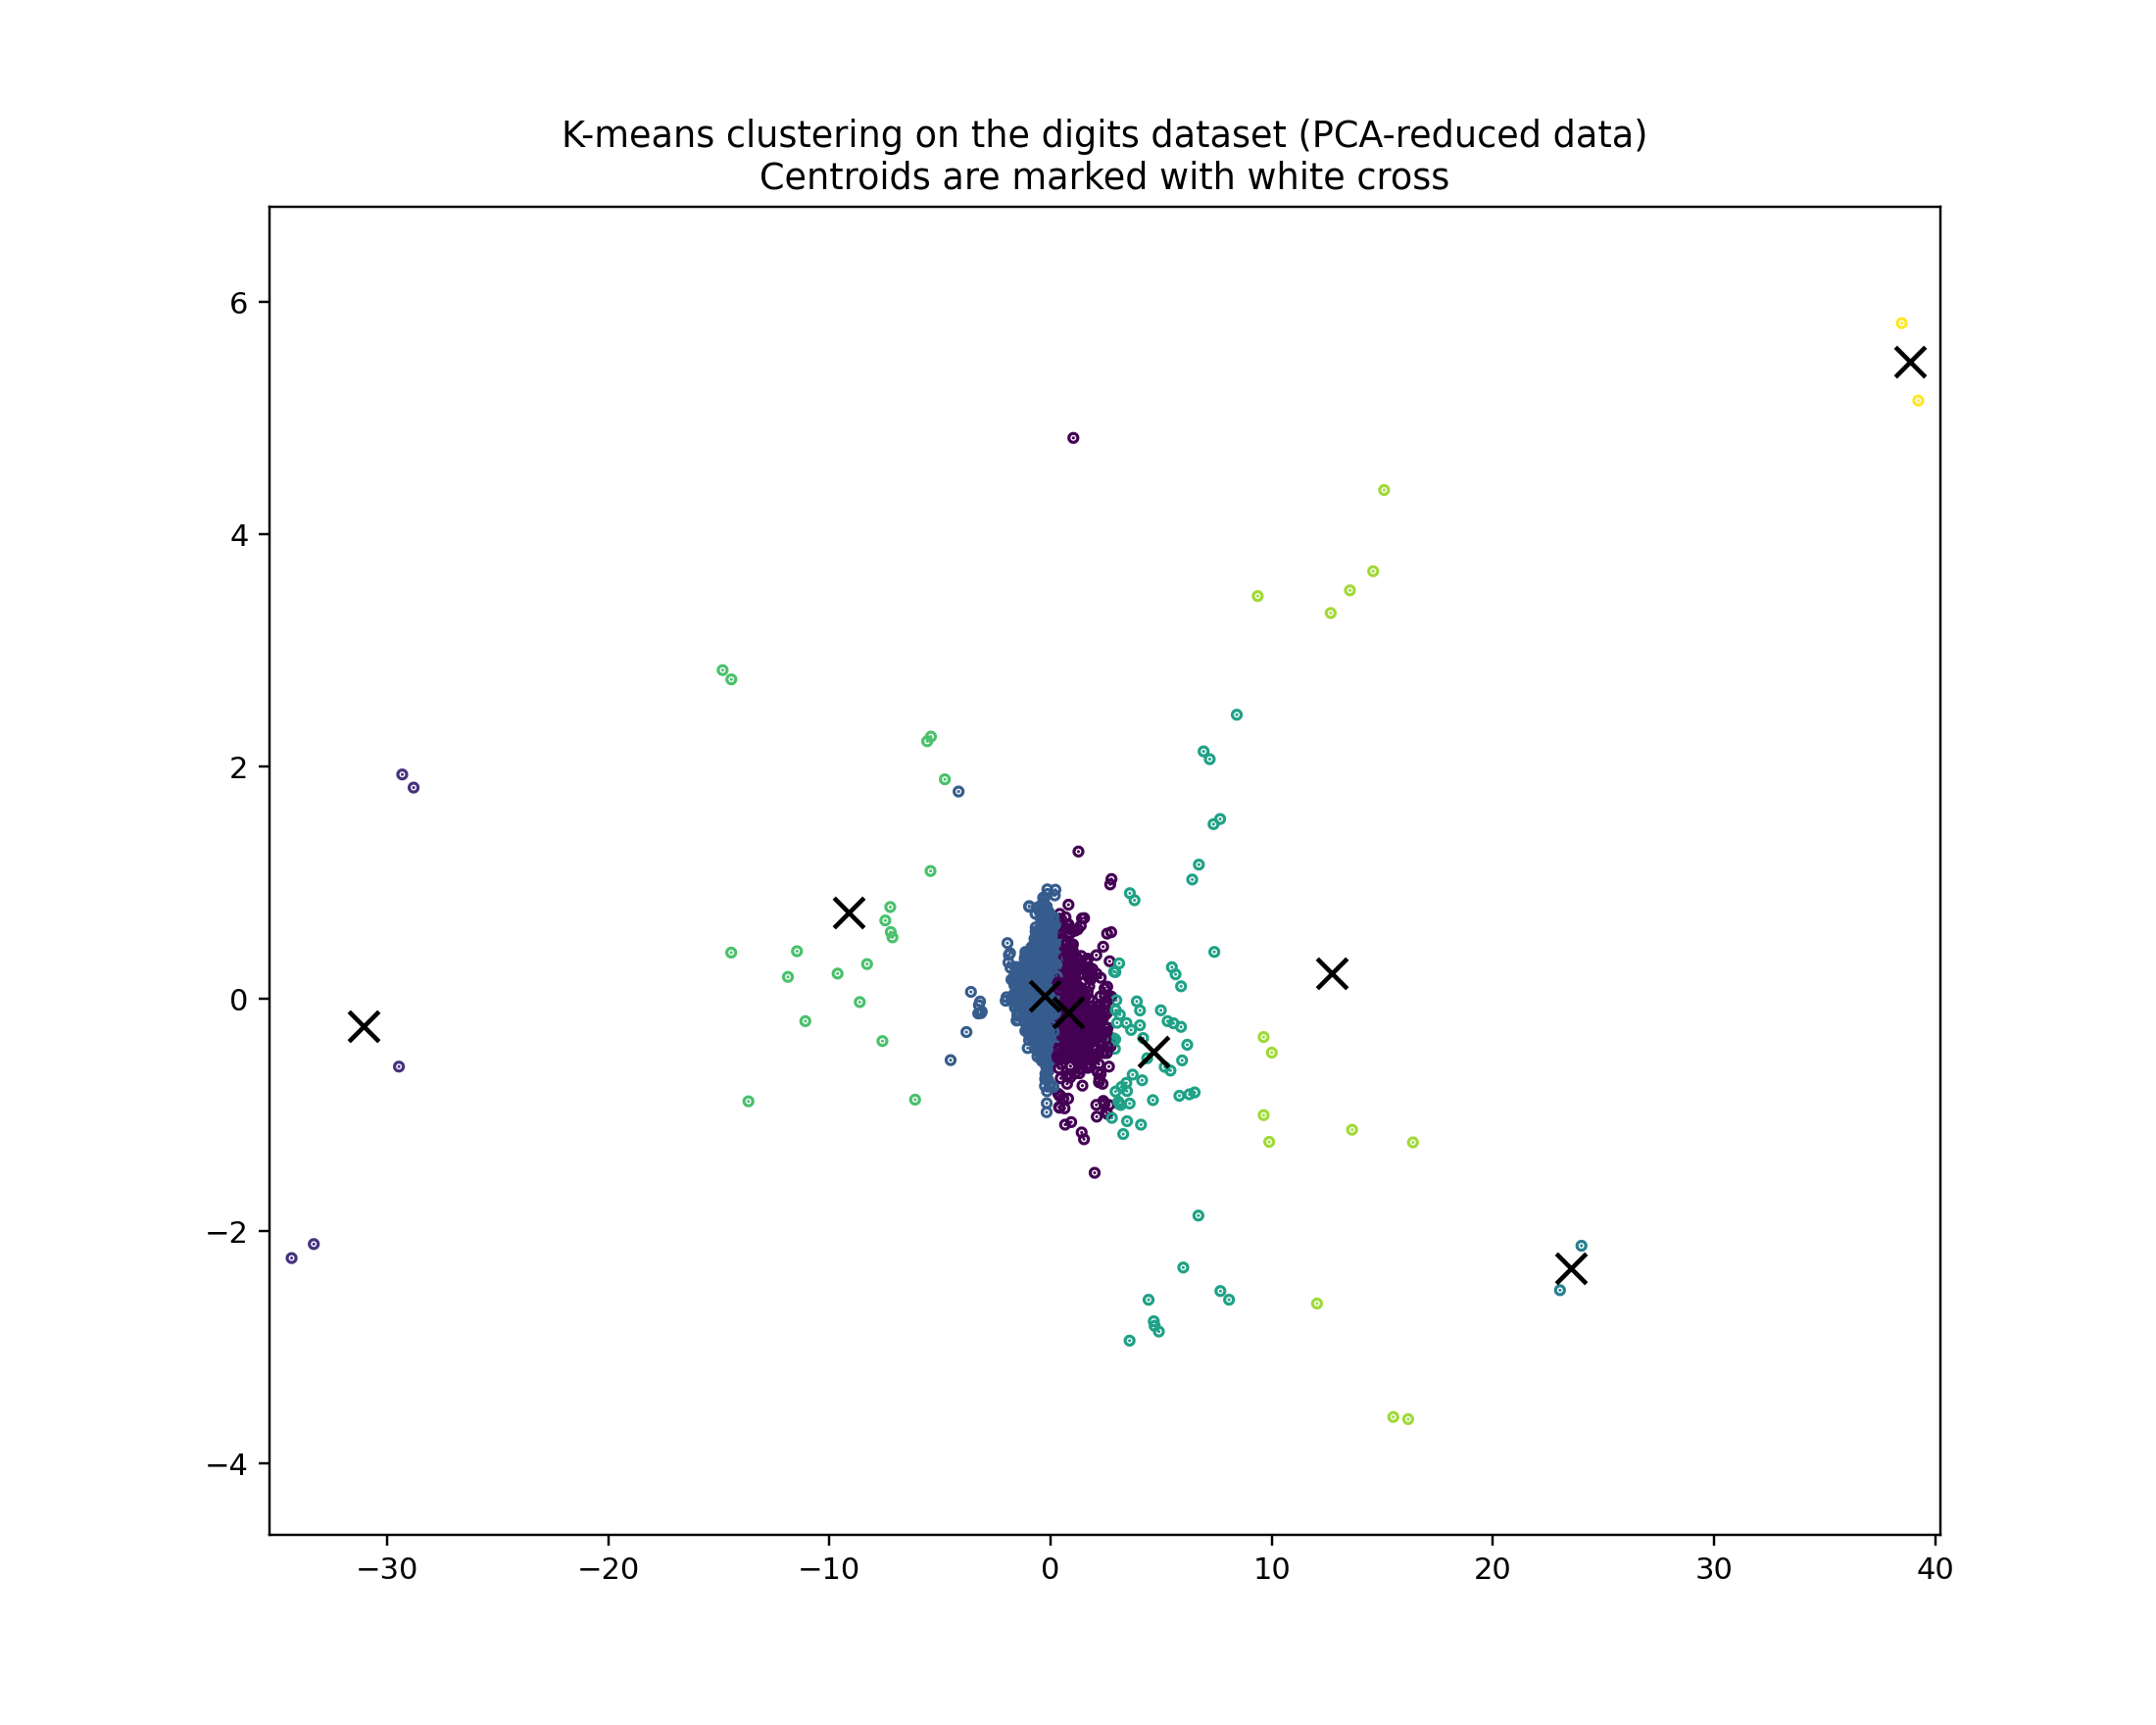

In [34]:
# k-means
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
# #############################################################################
# Visualize the results on PCA-reduced data

print(np.min(mats, axis=0), np.max(mats, axis=0))

reduced_data = PCA(n_components=2).fit_transform(mats[:, :])
kmeans = KMeans(init='k-means++', n_clusters=8, n_init=1)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
# xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h), np.arange(z_min, z_max, h))

# # Obtain labels for each point in mesh. Use last trained model.
# Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])

# # Put the result into a color plot
# Z = Z.reshape(xx.shape)
# plt.figure(1)
# plt.clf()
# plt.imshow(Z, interpolation='nearest',
#            extent=(xx.min(), xx.max(), yy.min(), yy.max(), zz.min(), zz.max()),
#            cmap=plt.cm.Paired,
#            aspect='auto', origin='lower')

# plt.plot(reduced_data[:, 0], reduced_data[:, 1], reduced_dataced_data[:, 2], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print(centroids)
print(x_min, x_max)
print(y_min, y_max)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()
ax.scatter(reduced_data[:, 0], reduced_data[:, 1],
            s=1, linewidths=3,
            c=labels)
ax.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=100, linewidths=3,
            color='black')
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
# ax.set_xlim(-100, 100)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
# ax.set_zlim(z_min, z_max)
# plt.xticks(())
# plt.yticks(())
# plt.zticks(())
plt.show()

[[-3.2444277e-01  3.7508529e-02 -2.1178048e-02]
 [ 1.6064629e+01 -1.7363763e-01  7.8247488e-01]
 [-3.1041876e+01 -2.3280810e-01  8.4888047e-01]
 [-9.1156225e+00  7.4243933e-01 -3.9953375e-01]
 [ 2.2389193e+00 -2.8729904e-01  5.7783123e-02]
 [ 3.8870010e+01  5.4875693e+00 -2.2712922e+00]
 [ 6.6918736e+00 -3.0142069e-01  1.1178196e-01]
 [ 4.0556601e-01 -6.0194556e-02  3.9156515e-02]]
-35.31731414794922 40.243499755859375
-4.616739749908447 6.821113109588623
-3.5666849613189697 4.73657488822937


<IPython.core.display.Javascript object>


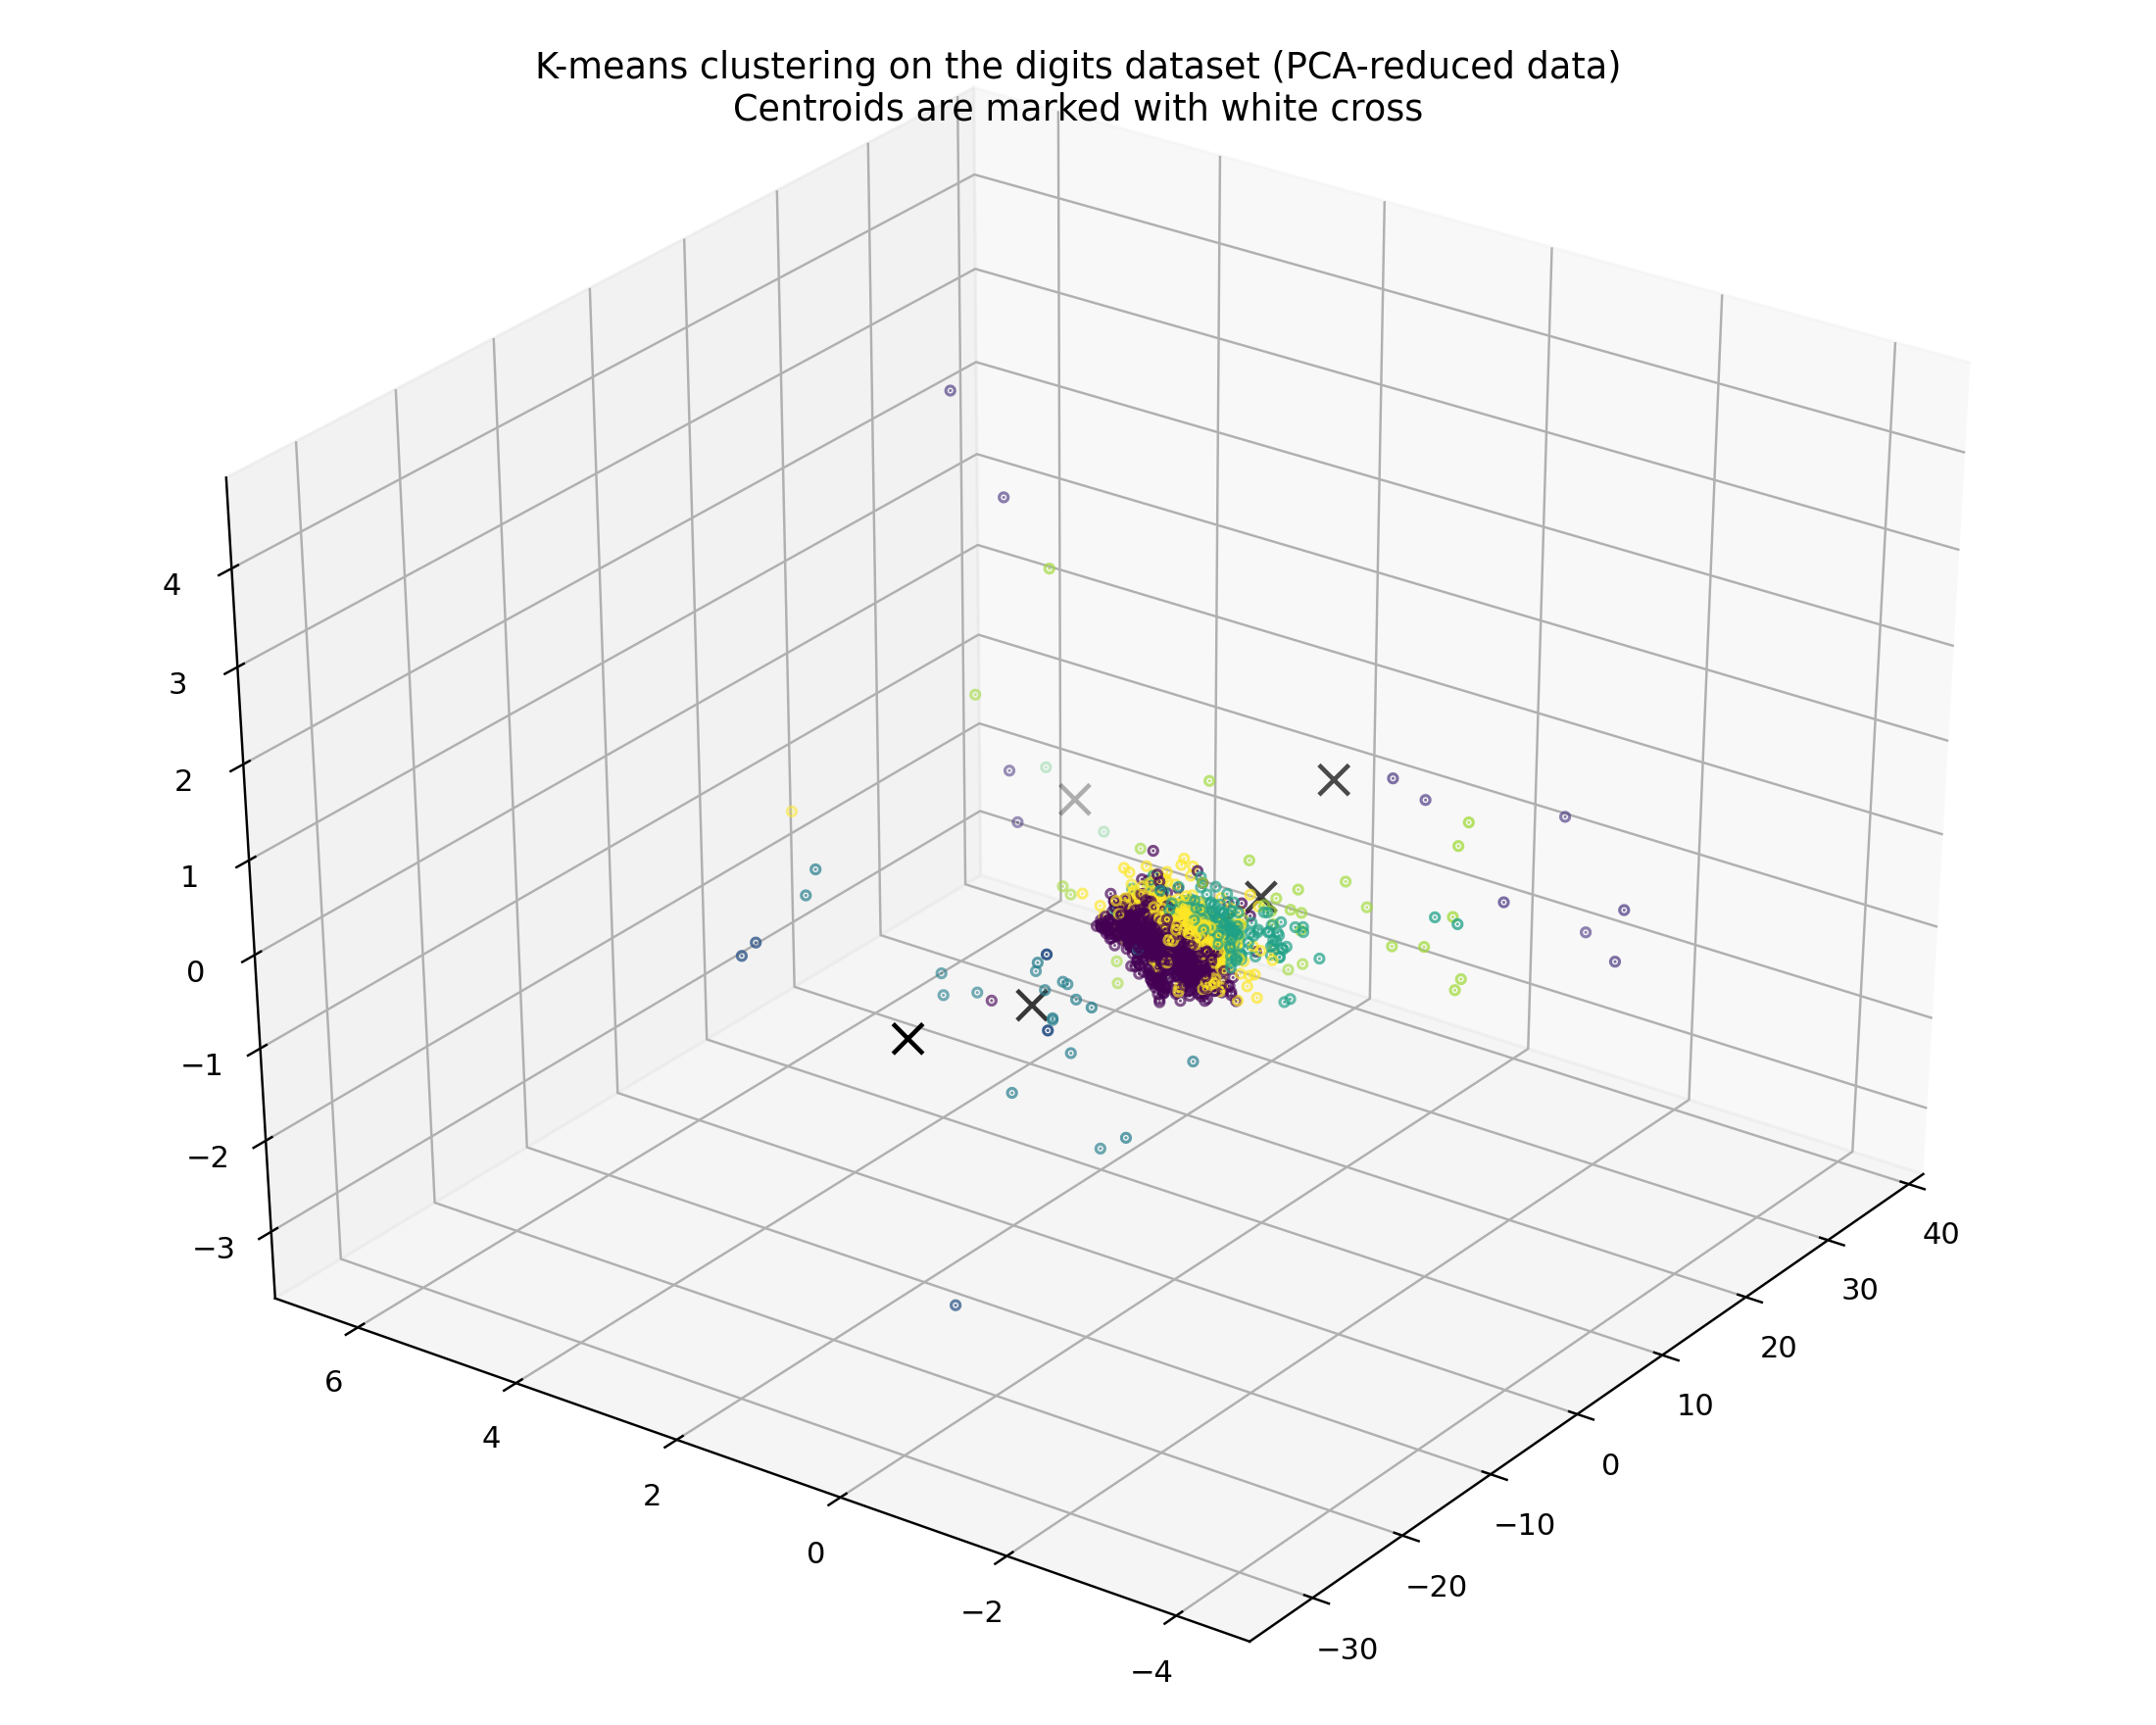

In [36]:
# k-means
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=3).fit_transform(mats[:, :])
kmeans = KMeans(init='k-means++', n_clusters=8, n_init=1)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
z_min, z_max = reduced_data[:, 2].min() - 1, reduced_data[:, 2].max() + 1
# xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h), np.arange(z_min, z_max, h))

# # Obtain labels for each point in mesh. Use last trained model.
# Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])

# # Put the result into a color plot
# Z = Z.reshape(xx.shape)
# plt.figure(1)
# plt.clf()
# plt.imshow(Z, interpolation='nearest',
#            extent=(xx.min(), xx.max(), yy.min(), yy.max(), zz.min(), zz.max()),
#            cmap=plt.cm.Paired,
#            aspect='auto', origin='lower')

# plt.plot(reduced_data[:, 0], reduced_data[:, 1], reduced_dataced_data[:, 2], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print(centroids)
print(x_min, x_max)
print(y_min, y_max)
print(z_min, z_max)
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2],
            s=1, linewidths=3,
            c=labels)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
            marker='x', s=100, linewidths=3,
            color='black')
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)
# plt.xticks(())
# plt.yticks(())
# plt.zticks(())
plt.show()

<IPython.core.display.Javascript object>


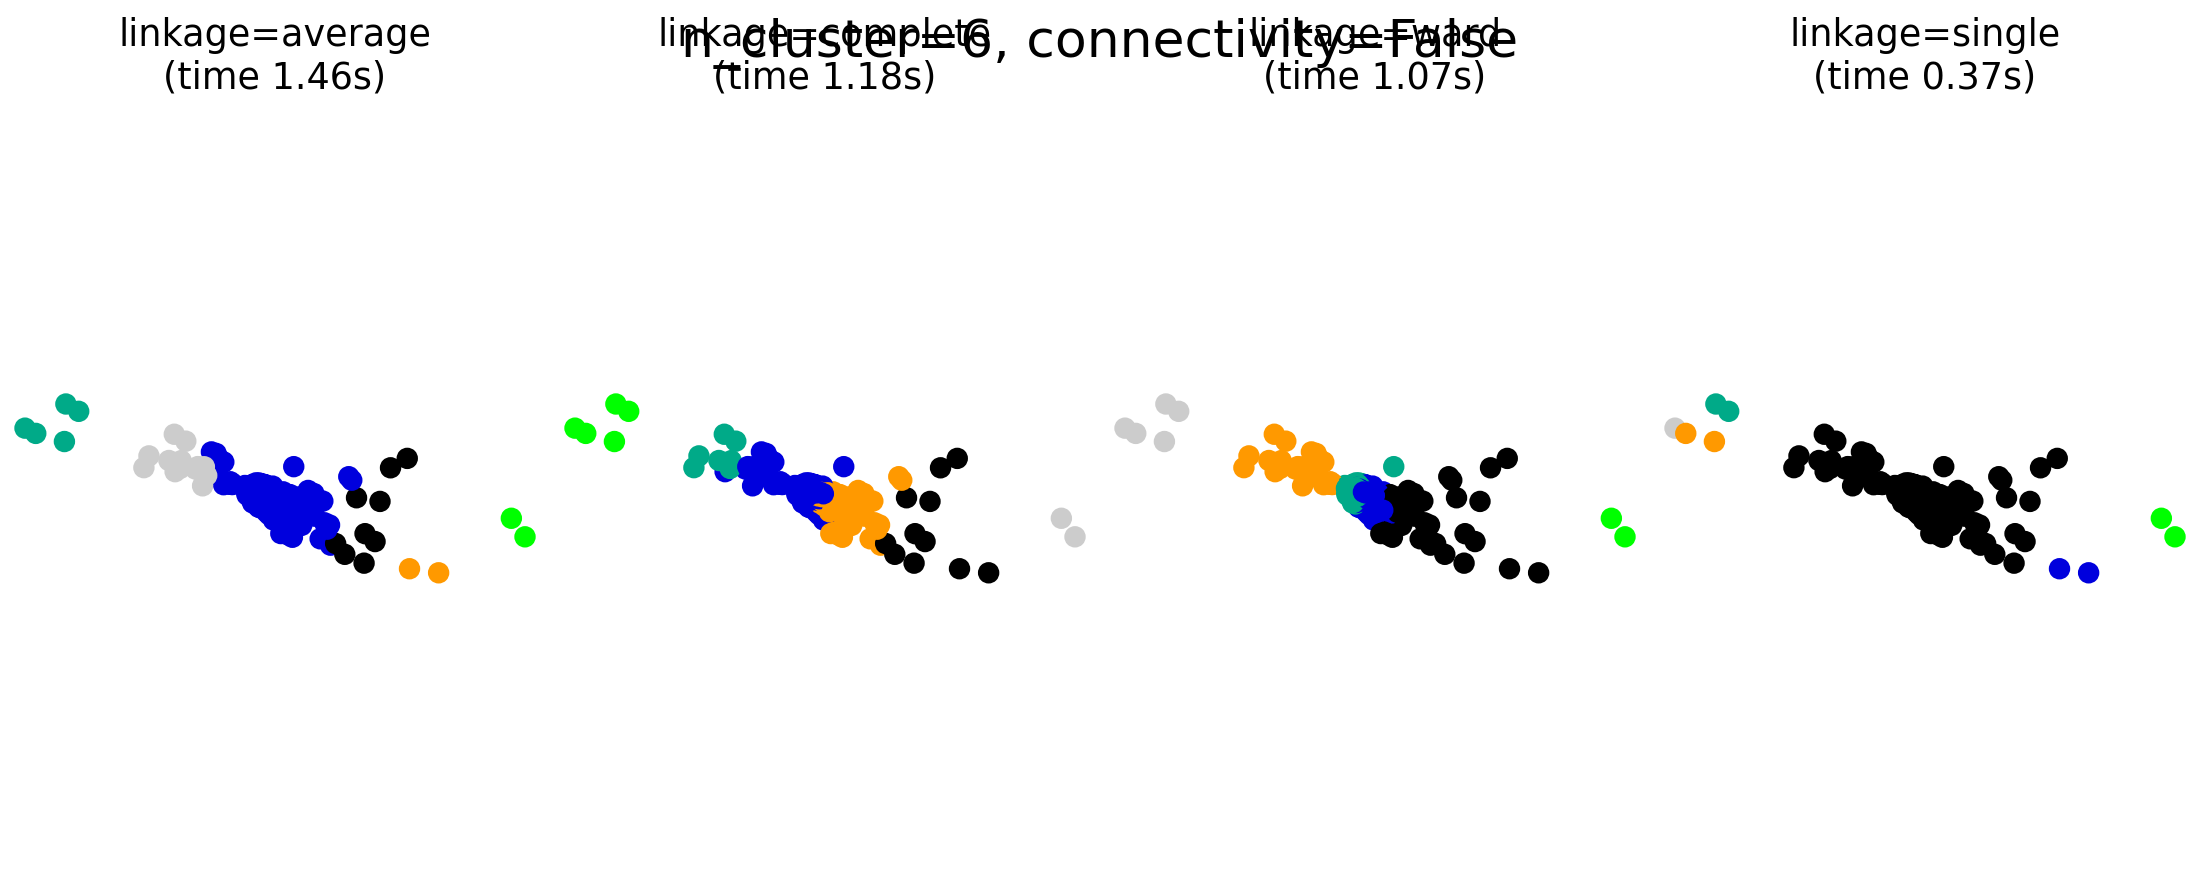

<IPython.core.display.Javascript object>


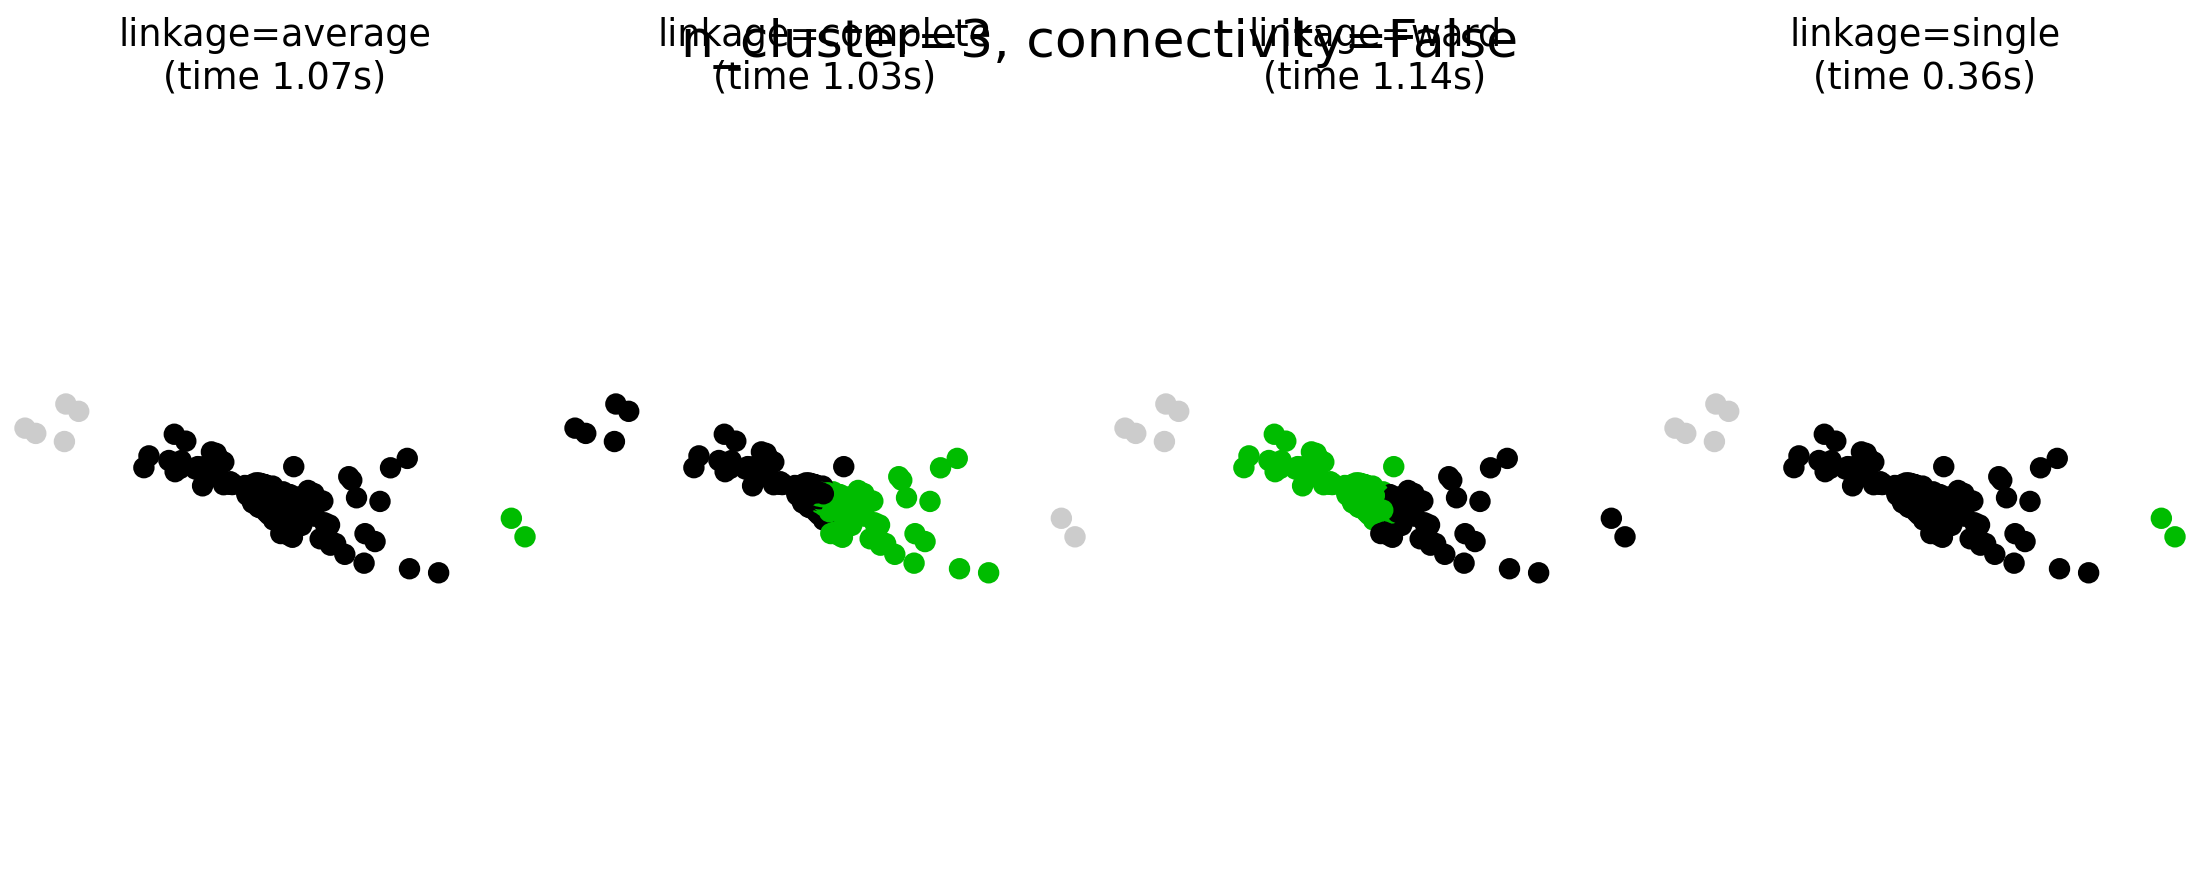

In [39]:
# Agglomerative clustering
import time
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph


# print(X.shape)

# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
# knn_graph = kneighbors_graph(mats, 500, include_self=False)

for connectivity in (None,):
    for n_clusters in (6, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(('average',
                                         'complete',
                                         'ward',
                                         'single')):
            plt.subplot(1, 4, index + 1)
            model = AgglomerativeClustering(linkage=linkage,
                                            connectivity=connectivity,
                                            n_clusters=n_clusters)
            t0 = time.time()
            model.fit(mats)
            elapsed_time = time.time() - t0
            plt.scatter(mats[:, 0], mats[:, 1], c=model.labels_,
                        cmap=plt.cm.nipy_spectral)
            plt.title('linkage=%s\n(time %.2fs)' % (linkage, elapsed_time),
                      fontdict=dict(verticalalignment='top'))
            plt.axis('equal')
            plt.axis('off')

            plt.subplots_adjust(bottom=0, top=.89, wspace=0,
                                left=0, right=1)
            plt.suptitle('n_cluster=%i, connectivity=%r' %
                         (n_clusters, connectivity is not None), size=17)


plt.show()

<IPython.core.display.Javascript object>


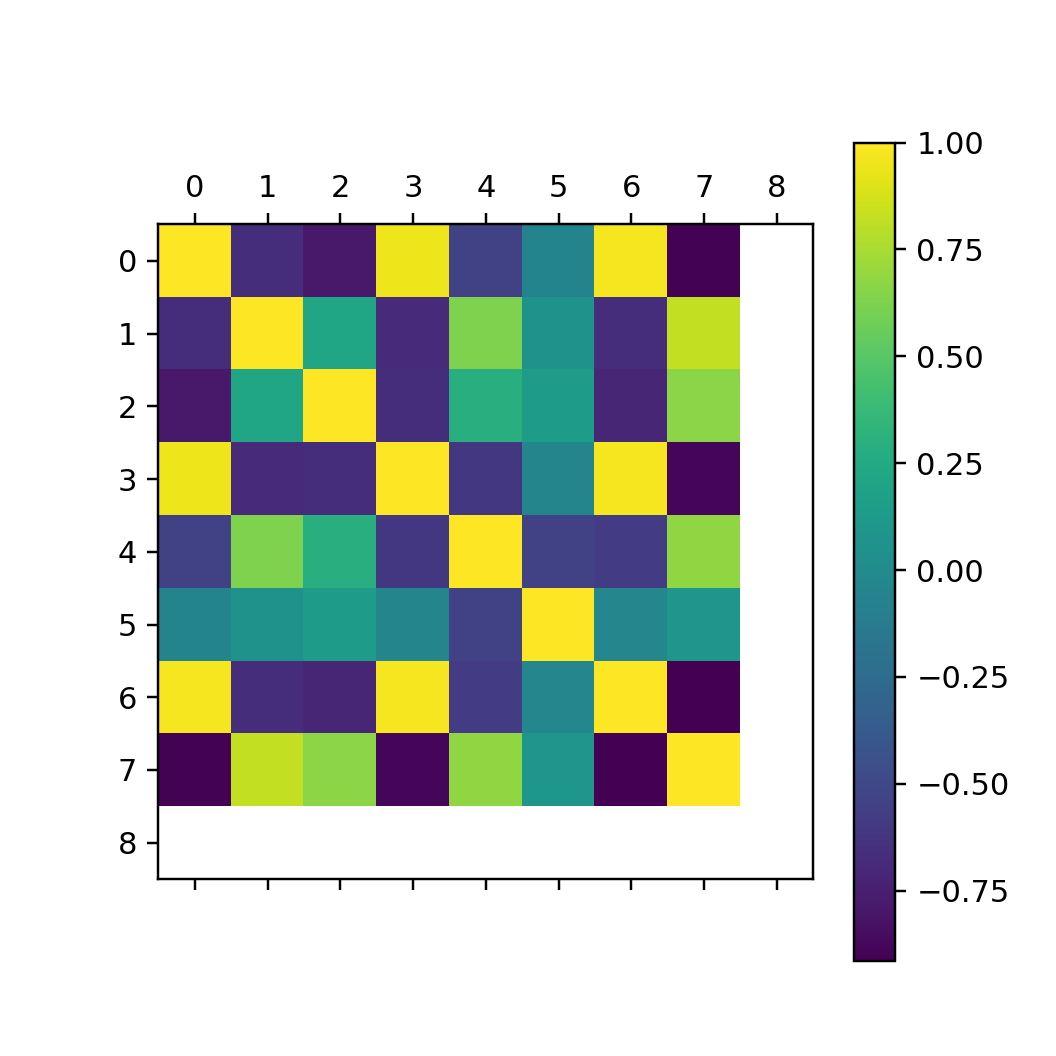

In [42]:
# covariance
# print(mats.shape)
from sklearn.covariance import EmpiricalCovariance
# cov = EmpiricalCovariance().fit(mats)
# print(cov.covariance_)
# fig = plt.figure()
# plt.matshow(cov.covariance_)
# plt.show()
corrcoefs = np.corrcoef(mats, rowvar=False)
# print(corrcoefs)
plt.matshow(corrcoefs)
plt.colorbar()
plt.show()
# mats = mats.reshape(-1, 3, 3)
# print(mats)
# print(mats.shape)
# norms = np.linalg.norm(mats, ord='fro', axis=(1,2))
# print(norms)
# diff = norms.reshape(norms.shape[0], 1, -1) - norms.reshape(1, norms.shape[0], -1)
# diff = np.squeeze(diff)
# print(diff)
# plt.matshow(diff)
# plt.show()

(6160, 9)
Estimated number of clusters: 1
Estimated number of noise points: 9
Silhouette Coefficient: 0.967


<IPython.core.display.Javascript object>


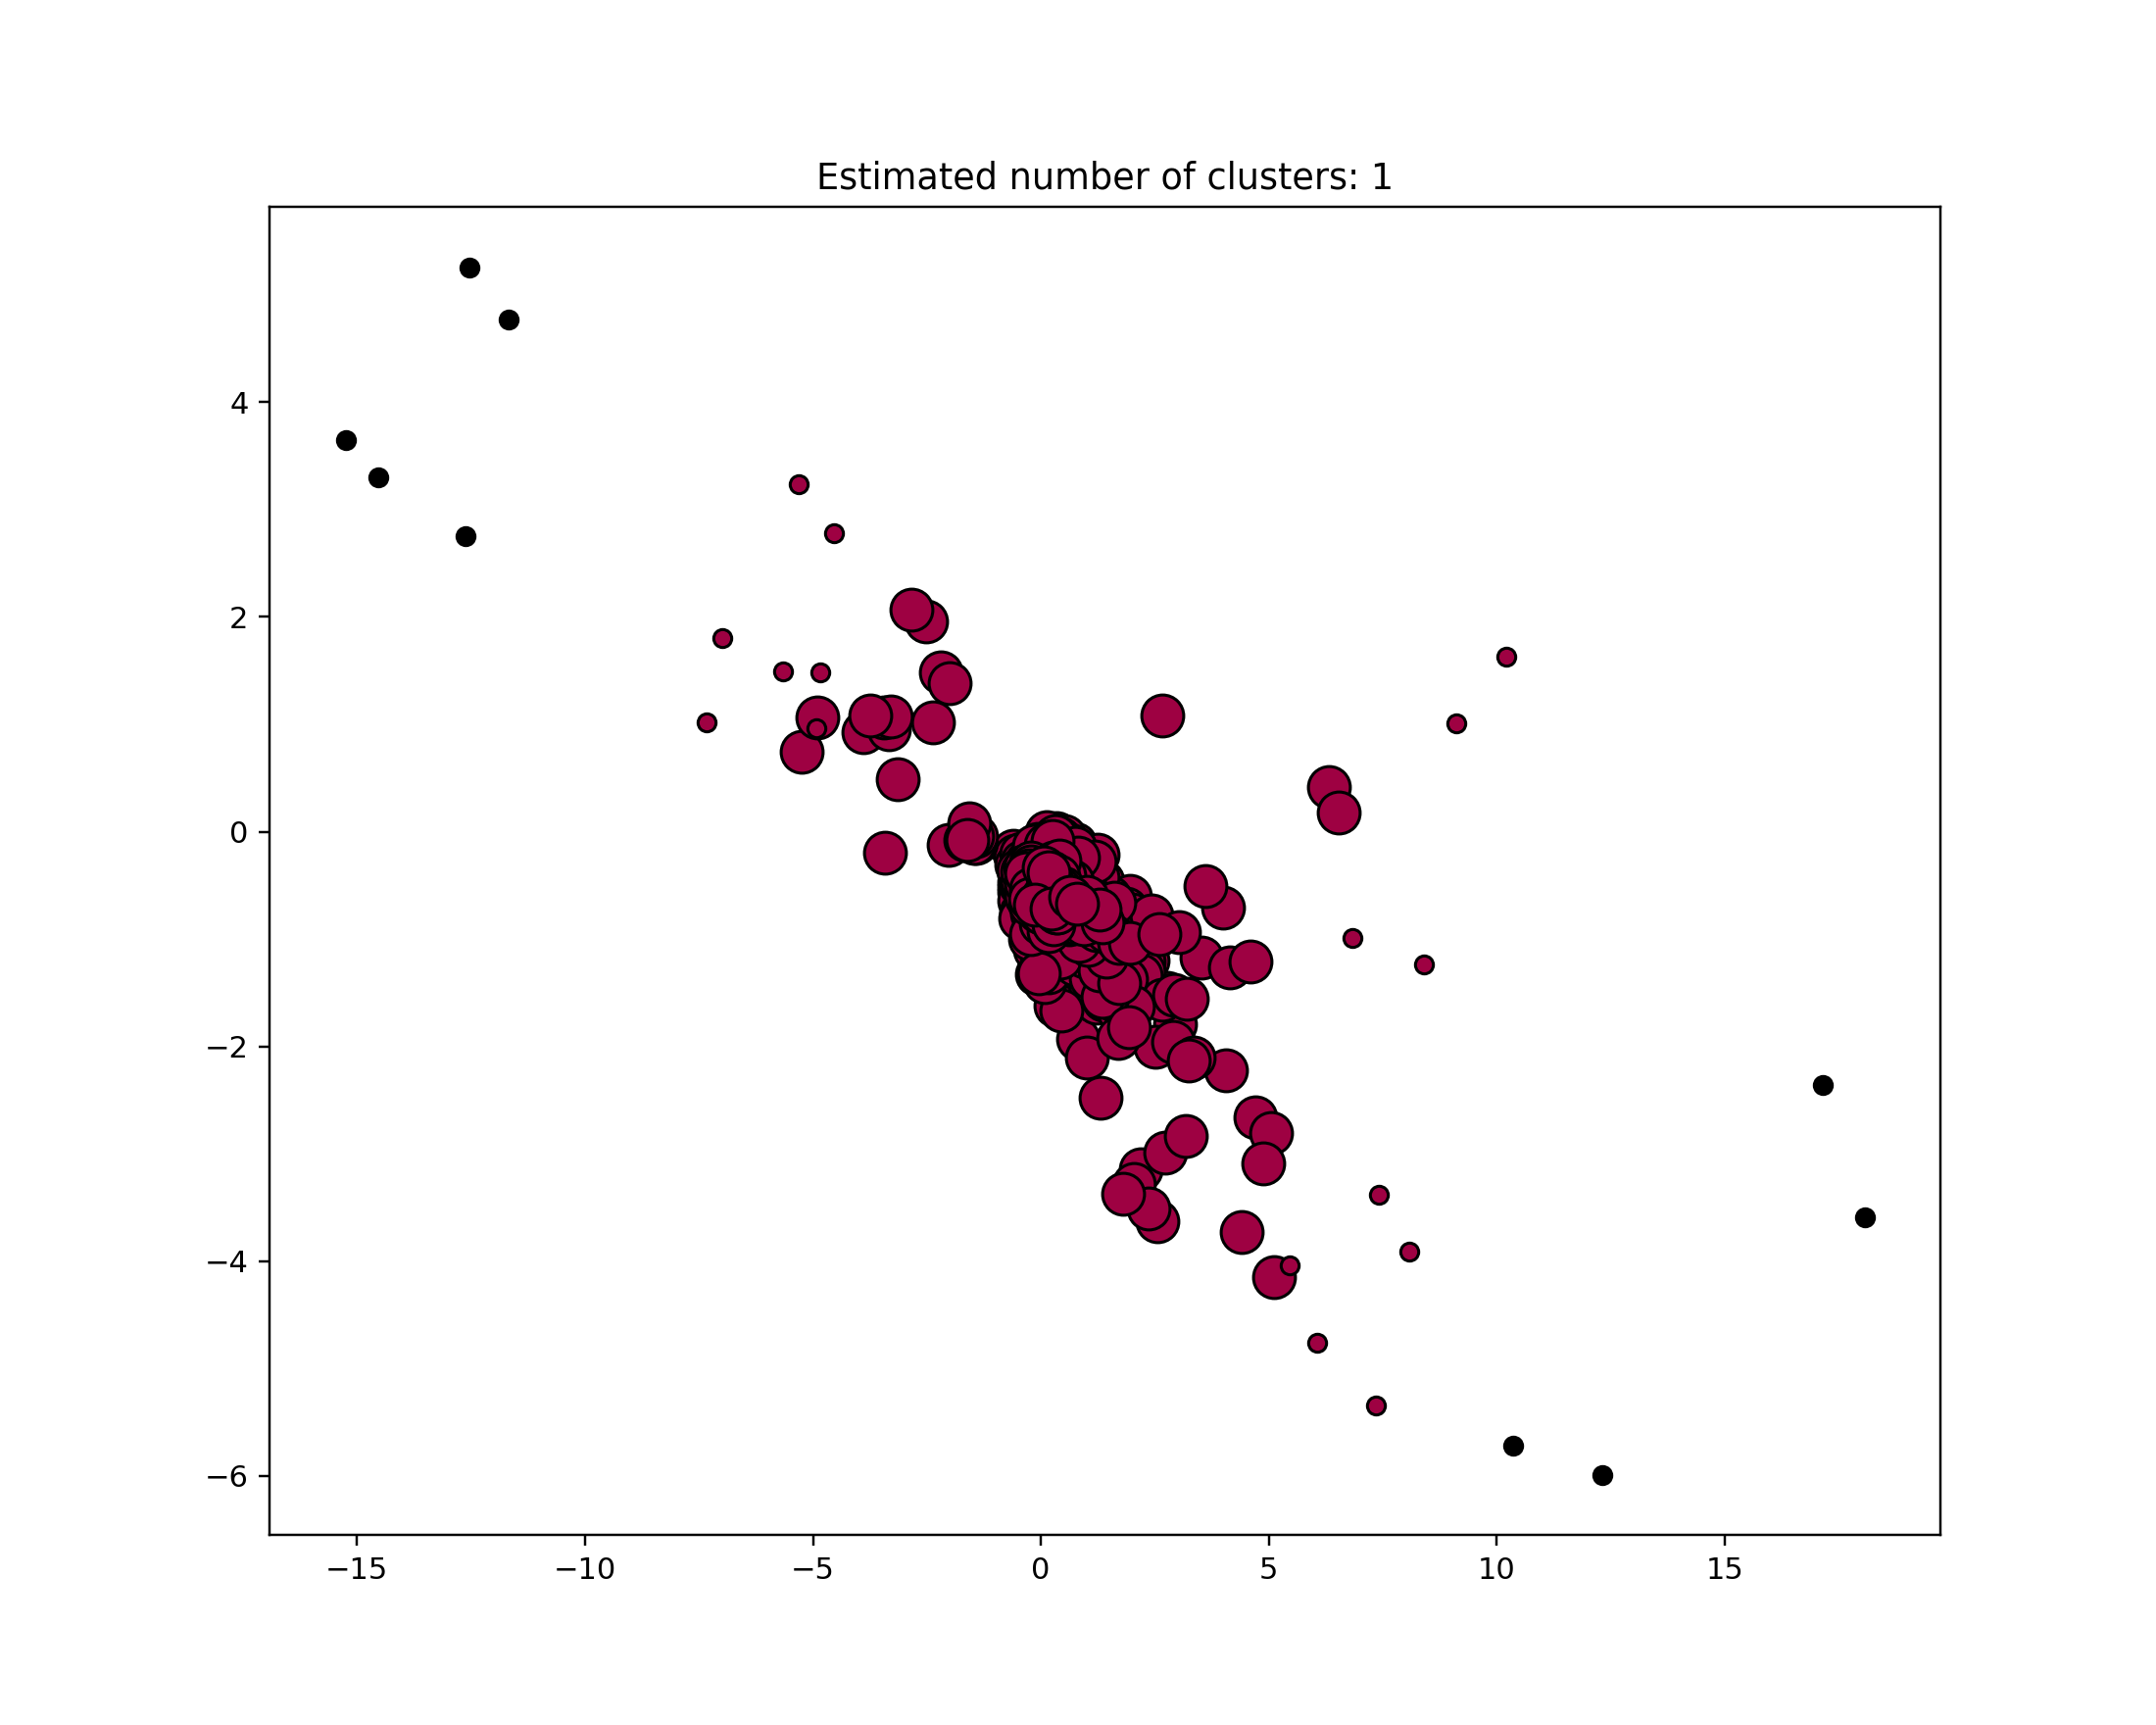

In [44]:
# DBSCAN

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Compute DBSCAN
print(mats.shape)
db = DBSCAN(eps=10, min_samples=200).fit(mats)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(mats, labels))

# #############################################################################
# Plot result
fig = plt.figure(figsize=(10, 8))
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = mats[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = mats[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [45]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets import make_blobs


# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-90).fit(mats)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(mats, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = mats[cluster_centers_indices[k]]
    plt.plot(mats[class_members, 0], mats[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in mats[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

KeyboardInterrupt: 

[[0.28865979 0.17522659]
 [0.63402062 0.14803625]
 [0.57731959 0.48036254]
 [0.4742268  0.51057402]]
[[[0.38659794 0.17220544]
  [0.48969072 0.17220544]
  [0.48969072 0.31722054]
  [0.38659794 0.31722054]]

 [[0.5        0.16012085]
  [0.62371134 0.16012085]
  [0.62371134 0.3081571 ]
  [0.5        0.3081571 ]]]
tensor([[[-2.2591e-02, -3.1277e-01,  6.9271e+01],
         [-1.2362e-01, -1.2054e-01,  5.1811e+01],
         [-2.3554e-03, -3.5041e-03,  1.0000e+00]],

        [[-4.3597e-02, -3.9986e-01,  9.0125e+01],
         [-1.1397e-01, -1.0488e-01,  4.7703e+01],
         [-2.3554e-03, -3.5041e-03,  1.0000e+00]]])
tensor([[[-0.0226, -0.5337,  0.3571],
         [-0.0725, -0.1205,  0.1565],
         [-0.4569, -1.1599,  1.0000]],

        [[-0.0436, -0.6822,  0.4646],
         [-0.0668, -0.1049,  0.1441],
         [-0.4569, -1.1599,  1.0000]]])


<IPython.core.display.Javascript object>


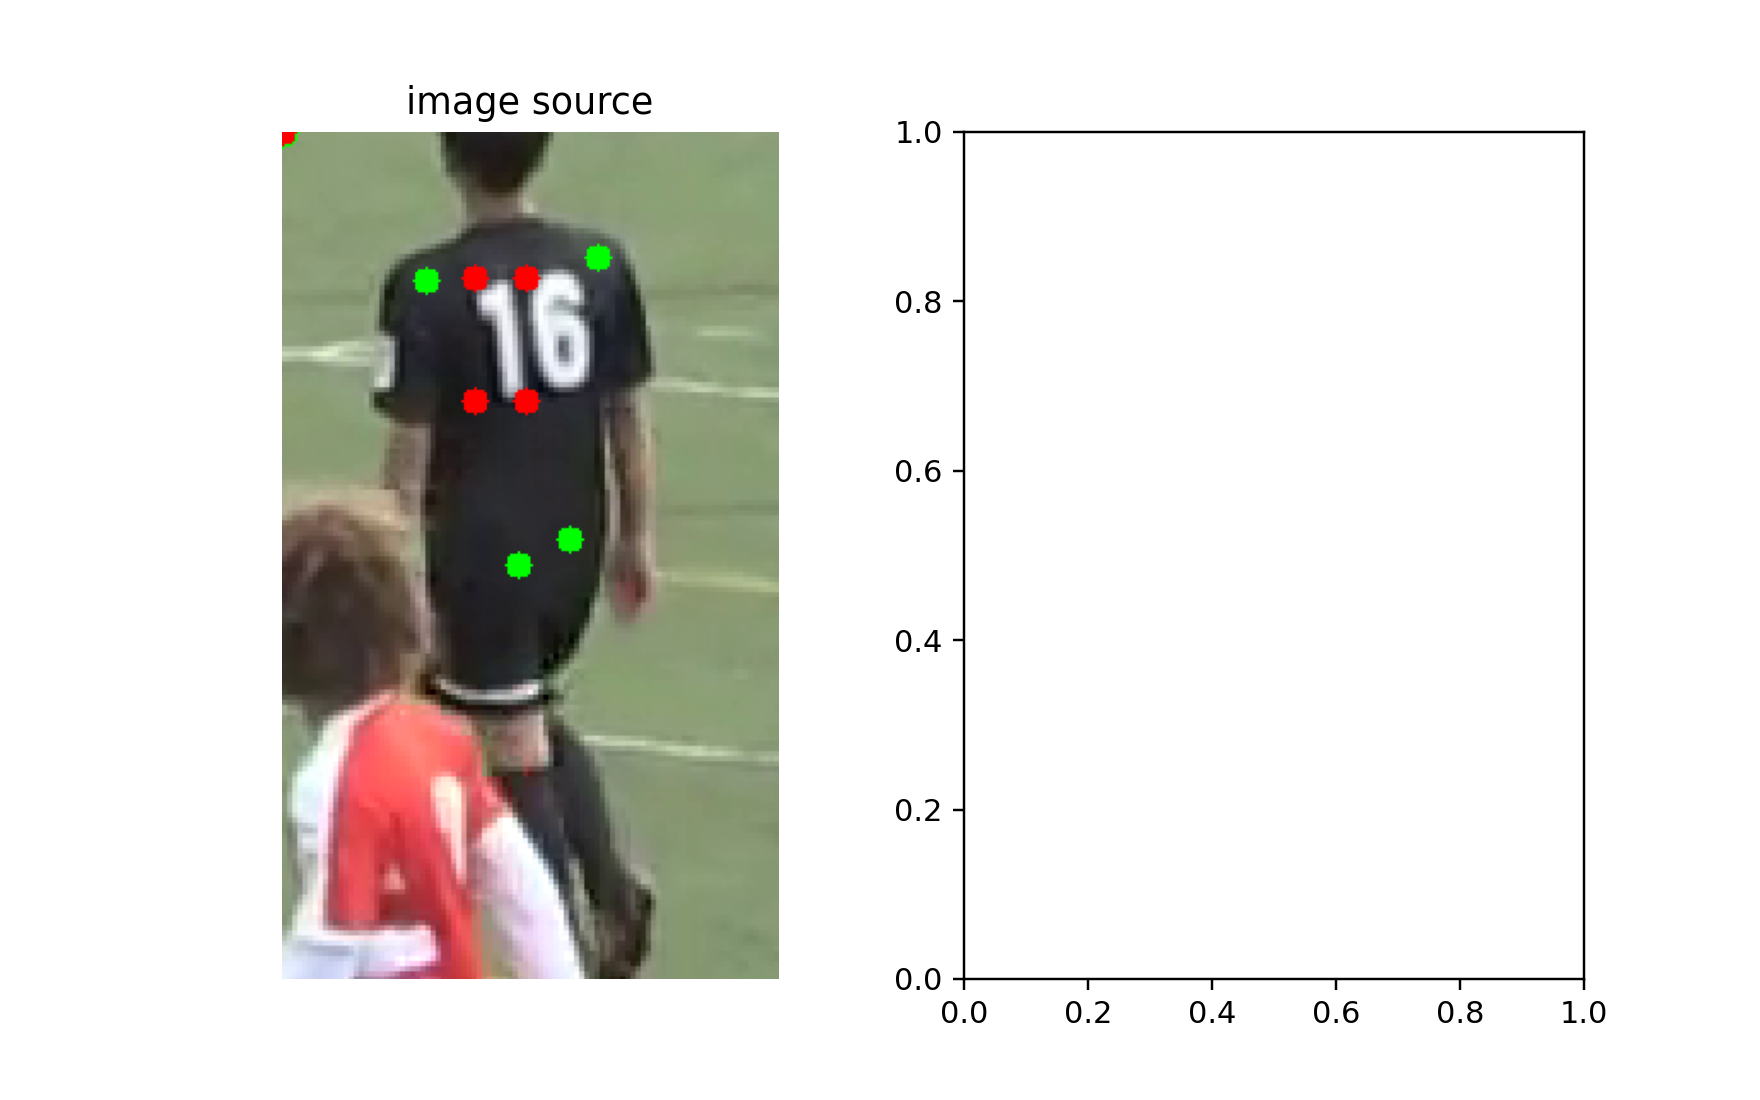

In [28]:
"""

Warp image using perspective transform
======================================

"""


    

# read the image with OpenCV
# print(os.path.abspath('../../datasets/jnw/total/4770_2.png'))
# img: np.ndarray = cv2.imread('../../../../datasets/jnw/total/new_3285_1.png')

# convert to torch tensor
data: torch.tensor = kornia.image_to_tensor(img, keepdim=False)  # BxCxHxW

# the source points are the region to crop corners
# points_src = torch.tensor([[
#     [82., 60.], [139., 59.], [132., 121.], [101., 121.],
# ]])

img_size = np.array([d['width'], d['height']])

single_instance = d['annotations'][0]

keypoints = np.array([[single_instance['keypoints'][3*i], single_instance['keypoints'][3*i+1]] \
for i in range(len(single_instance['keypoints']) // 3)])

# print(keypoints.shape)

# keypoints_min = np.min(keypoints, axis=0)
# keypoints_max = np.max(keypoints, axis=0)
# keypoints_size = keypoints_max - keypoints_min
keypoints = keypoints / img_size
print(keypoints)

points_src = torch.tensor([[[single_instance['keypoints'][3*i], single_instance['keypoints'][3*i+1]] \
for i in range(len(single_instance['keypoints']) // 3)]], dtype=torch.float).repeat(2,1,1)

digit_bbox_points = np.array([[
    [digit_bbox[0], digit_bbox[1]], [digit_bbox[2], digit_bbox[1]], [digit_bbox[2], digit_bbox[3]], [digit_bbox[0], digit_bbox[3]],
] for digit_bbox in single_instance['digit_bboxes']])

digit_bbox_points = digit_bbox_points / img_size
print(digit_bbox_points)

points_dst = torch.tensor([[
    [digit_bbox[0], digit_bbox[1]], [digit_bbox[2], digit_bbox[1]], [digit_bbox[2], digit_bbox[3]], [digit_bbox[0], digit_bbox[3]],
] for digit_bbox in single_instance['digit_bboxes']], dtype=torch.float)

# print(points_src, points_dst)

# compute perspective transform
M: torch.tensor = kornia.get_perspective_transform(points_src, points_dst)

print(M)

points_src = torch.tensor([keypoints], dtype=torch.float).repeat(2,1,1)
points_dst = torch.tensor(digit_bbox_points, dtype=torch.float)
M = kornia.get_perspective_transform(points_src, points_dst)
print(M)




points_dst_pred = kornia.transform_points(M, points_src)
# print(points_dst_pred)
# equivalent
# points_dst_pred = torch.matmul(M, kornia.convert_points_to_homogeneous(points_src).permute(0,2,1))
# print(kornia.convert_points_from_homogeneous(points_dst_pred.permute(0,2,1)))

# warp the original image by the found transform
# data_warp: torch.tensor = kornia.warp_perspective(data.float(), M, dsize=(h, w))

# convert back to numpy
# img_warp: np.ndarray = kornia.tensor_to_image(data_warp.byte())

# draw points into original image
for i in range(4):
    center = tuple(points_src[0, i].long().numpy())
    img = cv2.circle(img.copy(), center, 5, (0, 255, 0), -1)
    center = tuple(points_dst[0, i].long().numpy())
    img = cv2.circle(img.copy(), center, 5, (255, 0, 0), -1)

# create the plot
fig, axs = plt.subplots(1, 2, figsize=(8, 5))
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('image source')
axs[0].imshow(img)

# axs[1].axis('off')
# axs[1].set_title('image destination')
# axs[1].imshow(img_warp)